In [2]:
"Single firm notebook"

'Single firm notebook'

We pick one firm and plot its

- associated SSP,
- optimal emission,
- optimal production,
- optimal value.

This was the study of the [paper](https://cnrs.hal.science/hal-03458299/document).


In [3]:
import time

import matplotlib.pyplot as plt
import numpy as np

from firm import Firm
from utils import COLORS, SCENARIOS, SECTORS, set_plot_style

SEED = 1234  # for reproductibility
set_plot_style()
%config InlineBackend.figure_format = 'retina'

# Set parameters


In [4]:
# Set maturities: t=0 corresponds to the year 2015
T_SSP_INITIAL = 2015.0
T_SSP_FINAL = 2100.0
T_FINAL = T_SSP_FINAL - T_SSP_INITIAL

In [5]:
# Pick a sector from SECTORS
SECTOR = SECTORS[1]
print(f"The firm belongs to the {SECTOR}")

The firm belongs to the Industrial Sector


In [6]:
# Define timegrid for plots
N_POINTS = 200
tab_t = np.linspace(0.0, T_FINAL, N_POINTS)

In [7]:
# Set the firm's parameters
params_firm = {
    "prod_0": 1.0,
    "r": 0.02,
    "sig": 0.1,
    "a": 0.1,
    "b": 0.1,
    "c": np.array([0.01, 0.01, 0.01]),
    "w_1": 0.05,
    "w_2": 0.02,
    "n_units": 1.0,
    "t_final": T_FINAL,
    "alpha": np.array([0.0, 0.0, 0.0]),
    "beta": np.array([0.1, 0.5, 0.8]),
    "theta": np.array([1.0, 1.0, 1.0]),
}

In [8]:
# Create dictionnary of firms for each scenario
firms_dict = {
    scenario: Firm(**params_firm, scenario=scenario, sector=SECTOR)
    for scenario in SCENARIOS
}
# Define unpenalized firm
params_firm_no_pen = params_firm.copy()
params_firm_no_pen.update({"w_1": 0.0, "w_2": 0.0})
firm_no_pen = Firm(**params_firm_no_pen, scenario=SCENARIOS[0], sector=SECTOR)

# SSP scenarios and optimal emissions

We pick one specific SSP and plot the different optimal functions.


In [9]:
SCENARIO = "SSP4-60"
firm0 = firms_dict[SCENARIO]

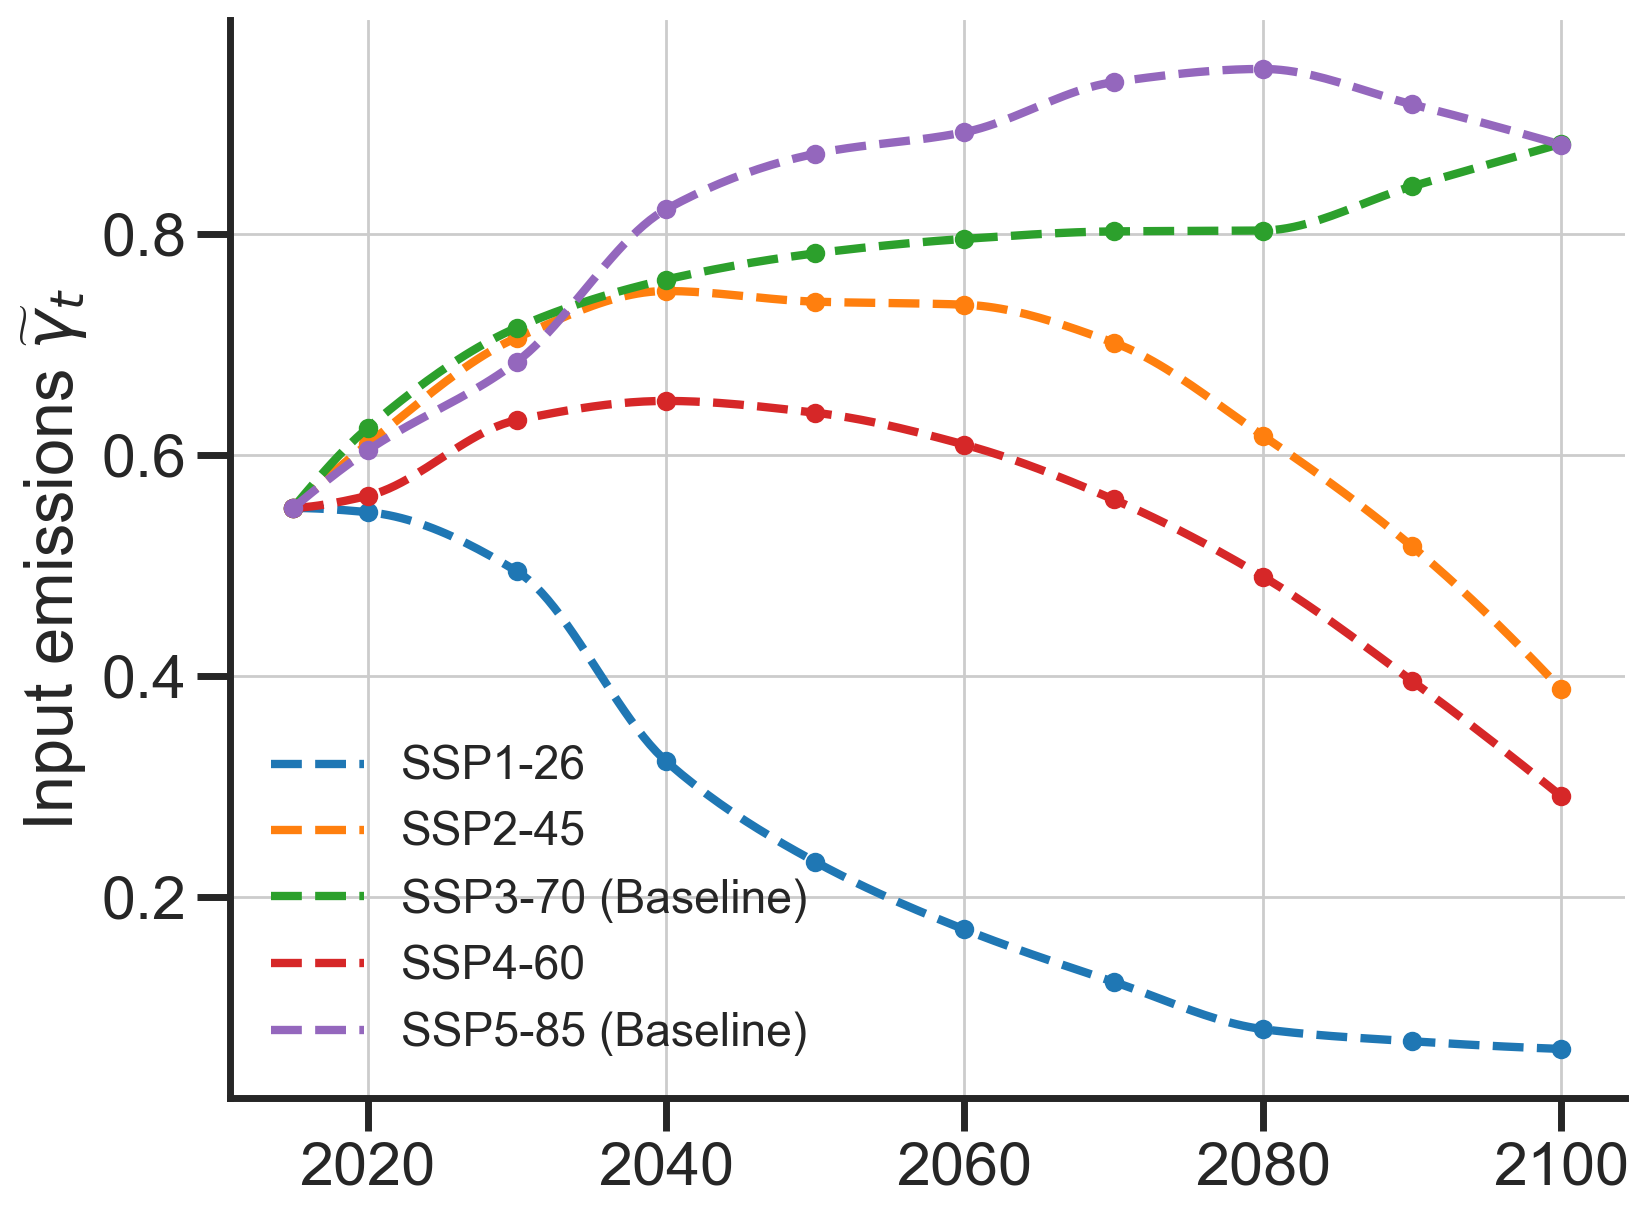

In [10]:
# Plot of the SSP scenarios
fig, ax = plt.subplots()
for i, name in enumerate(SCENARIOS):
    _firm = firms_dict[name]
    ax.plot(
        T_SSP_INITIAL + tab_t,
        _firm.f_scenario(tab_t),
        "--",
        label=name,
        color=COLORS[i],
    )
    ax.plot(
        T_SSP_INITIAL + _firm.ssp_time,
        _firm.ssp_values,
        ".",
        color=COLORS[i],
    )
ax.legend(
    loc="best",
    framealpha=0.0,
)
ax.set_ylabel("Input emissions $\\widetilde{{\\gamma}}_t$")
plt.show()

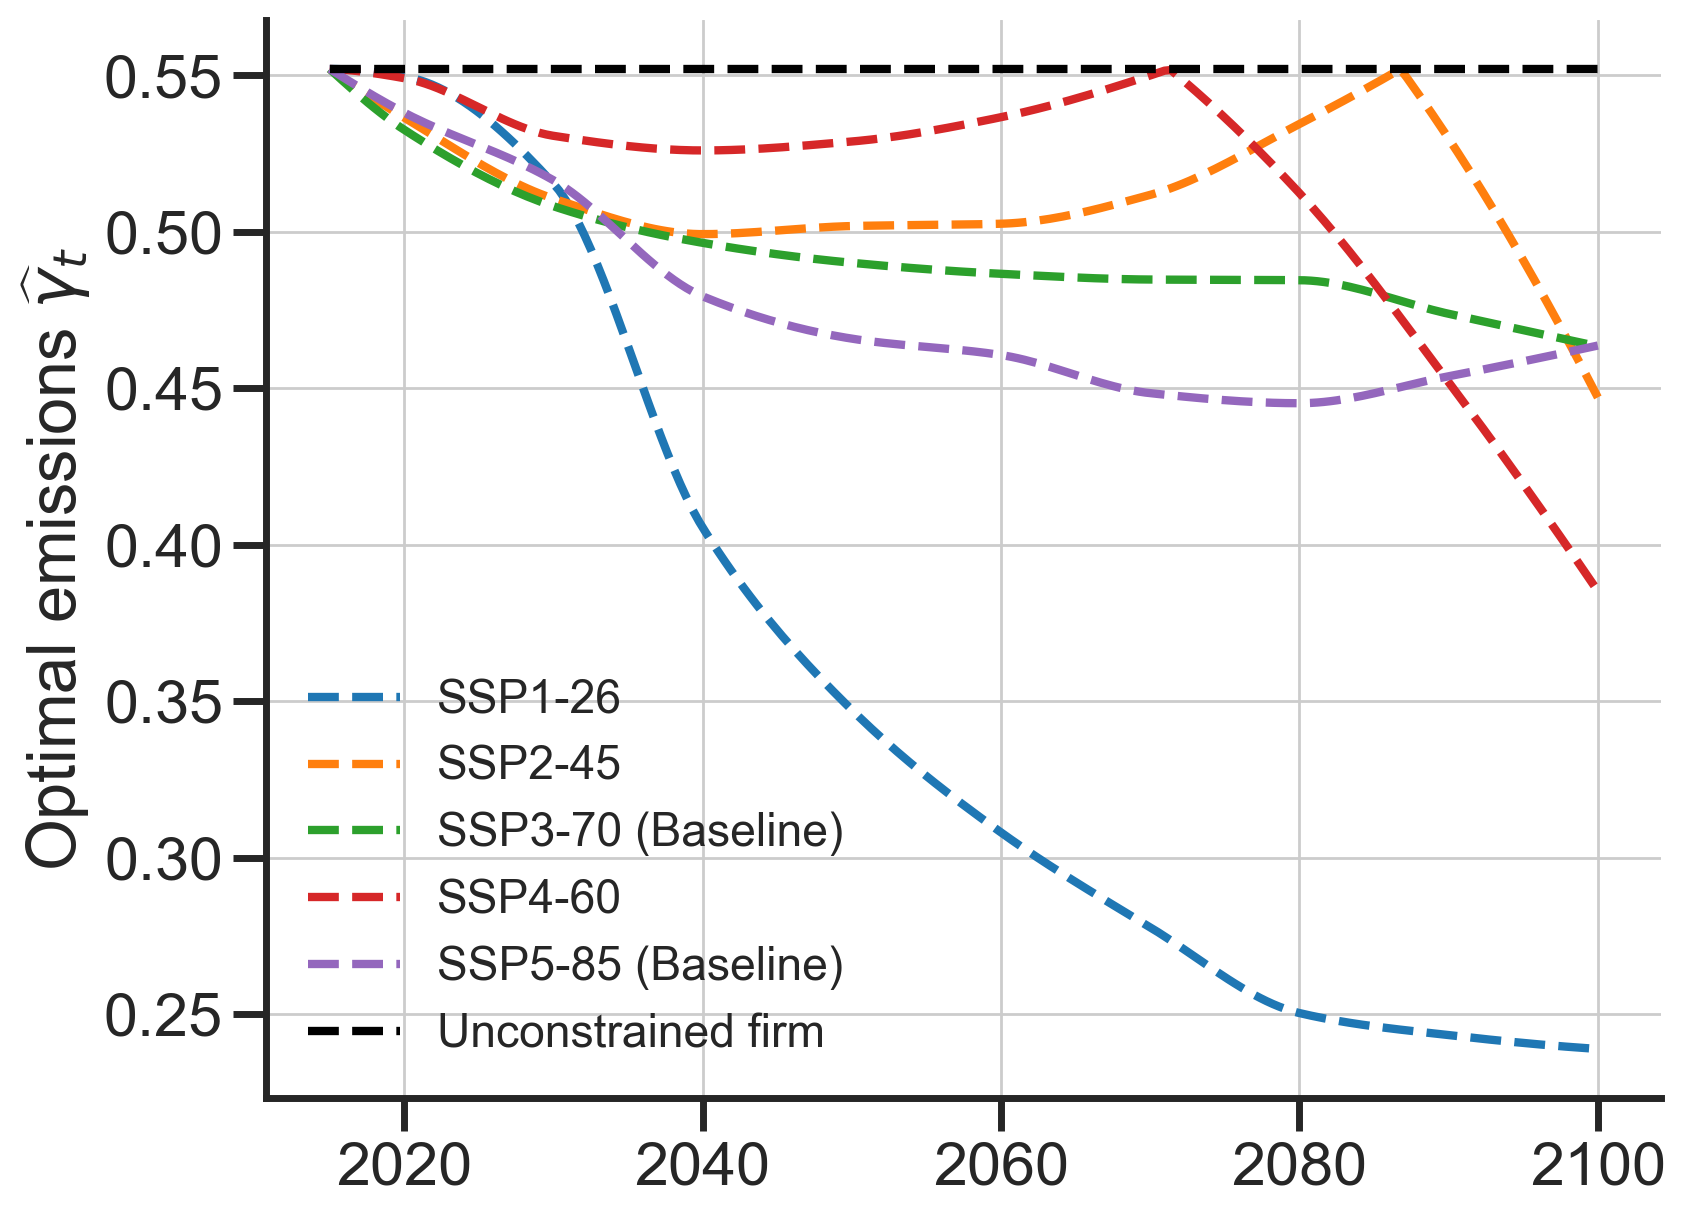

In [11]:
# Plot of the optimal emissions
fig, ax = plt.subplots()
for scenario_name, firm in firms_dict.items():
    ax.plot(
        T_SSP_INITIAL + tab_t,
        firm.gamma_optimal_energy(tab_t).sum(axis=0),
        "--",
        label=scenario_name,
    )
ax.plot(
    T_SSP_INITIAL + tab_t,
    firm0.gamma_zero_w * np.ones_like(tab_t),
    "k--",
    label="Unconstrained firm",
)
ax.set_ylabel("Optimal emissions $\\widehat{{\\gamma}}_t$")
ax.legend(loc="lower left", framealpha=0, ncol=1)
plt.show()

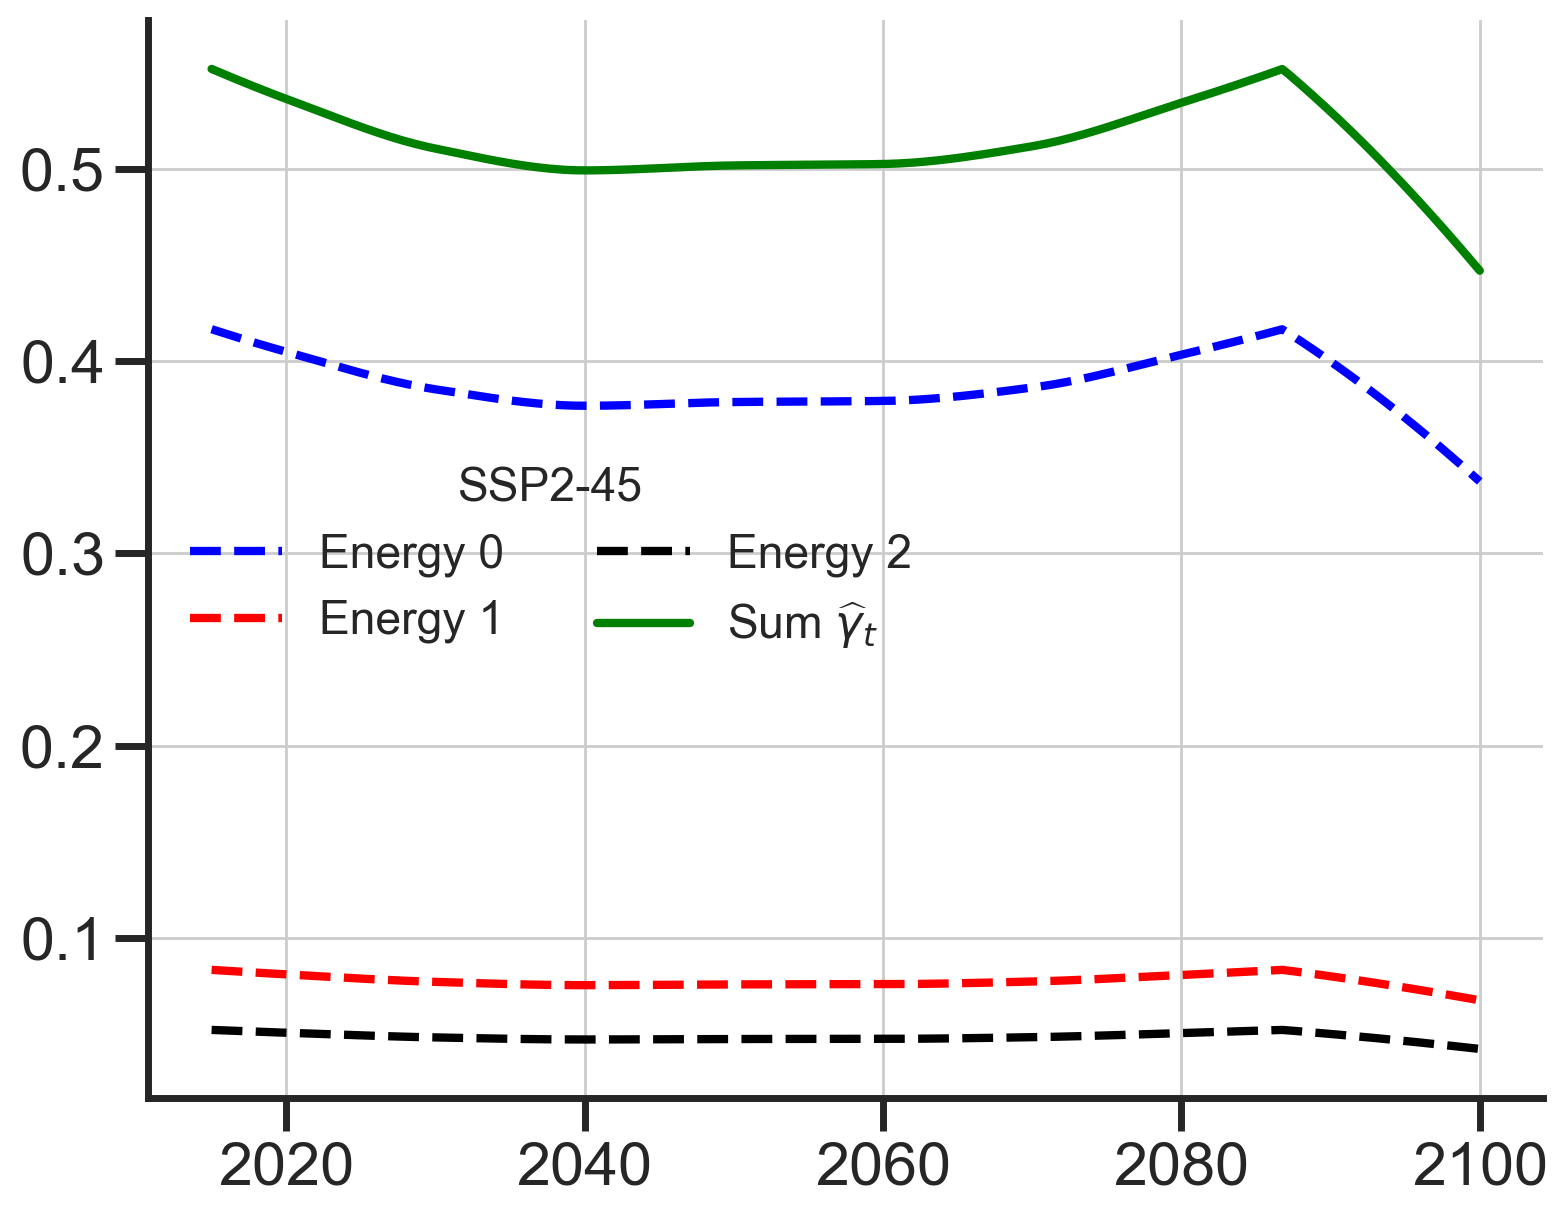

In [12]:
# For one given SSP, we decompose the optimal emissions response
# for each energy types.
markers = ["b--", "r--", "k--"]
SSP_NAME = "SSP2-45"
gam_opt = firms_dict[SSP_NAME].gamma_optimal_energy(tab_t)

fig, ax = plt.subplots()
for i in range(gam_opt.shape[0]):
    plt.plot(
        T_SSP_INITIAL + tab_t,
        gam_opt[i, :],
        markers[i],
        label=f"Energy {i}",
    )
ax.plot(
    T_SSP_INITIAL + tab_t,
    gam_opt.sum(axis=0),
    color="green",
    label="Sum $\\widehat{\\gamma}_t$",
)
ax.legend(
    framealpha=0.0,
    title=SSP_NAME,
    title_fontsize="x-small",
    loc="best",
    ncol=2,
)
plt.show()

# Optimal production


For all $u \geq t \geq 0$, conditionally on $\mathcal{F}_t$, the optimal log production $\widehat{p}_t$ is normal with conditional mean

$$ e^{-b (u - t)} \widehat{p}_t + m \big( t, u \big) $$

where

$$ m \big( t, u \big) = \frac{a}{b} (1 - e^{-b (u - t)}) + \int_t^u e^{-b (u - s)} \sum_{e} c_e \, \theta_{e,s} \, \widehat{\gamma}_{e, s} \, ds $$

and conditial variance

$$ \sigma^2 \frac{1-e^{-2 b (u-t)}}{2b}. $$


In [13]:
# Pick one Monte Carlo simulation
N_MC = 1

# Log production dictionary for all SSPs
log_prod_dict = {}
for scenario_name, firm in firms_dict.items():
    log_prod_dict[scenario_name] = firm.optimal_log_prod(
        tab_t=tab_t, n_mc=N_MC, seed=SEED
    ).flatten()

# Log production for the unpenalized firm
log_prod_no_pen = firm_no_pen.optimal_log_prod(
    tab_t=tab_t, n_mc=N_MC, seed=SEED
).flatten()

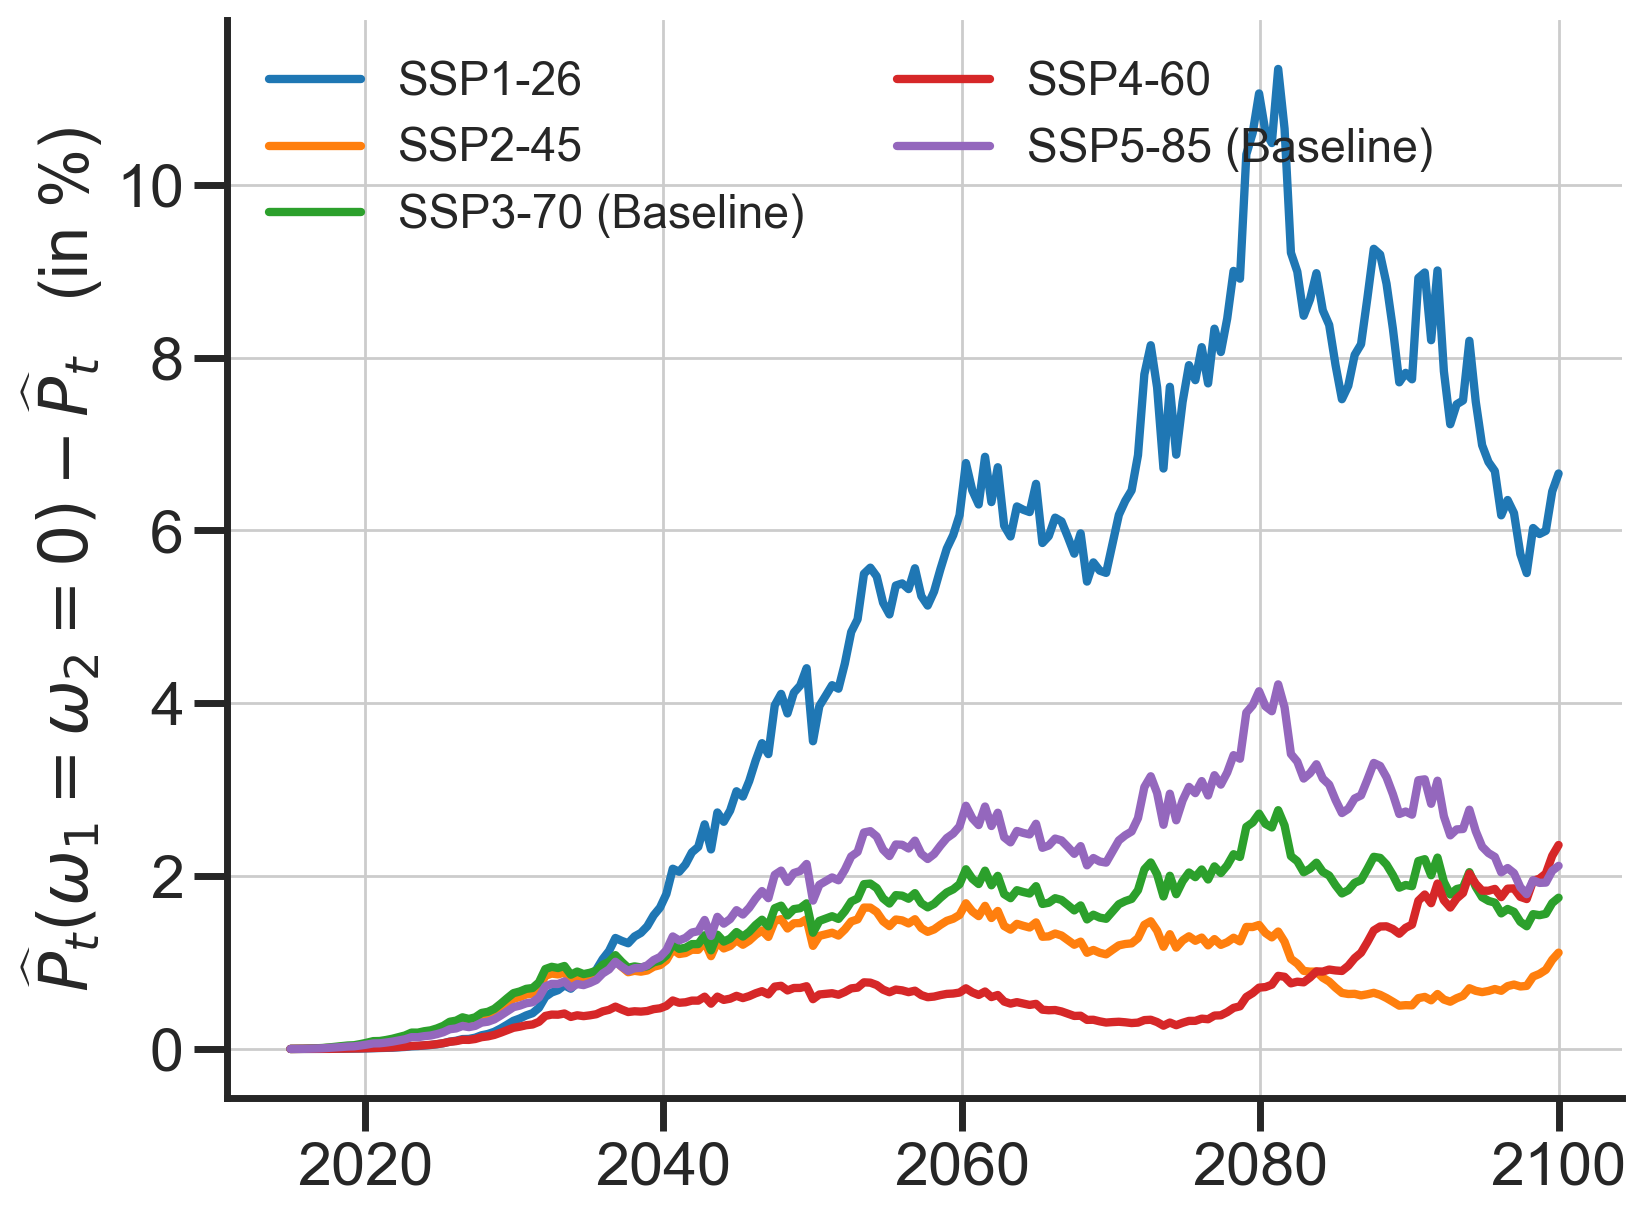

In [14]:
fig, ax = plt.subplots()
for scenario_name, log_prod in log_prod_dict.items():
    ax.plot(
        T_SSP_INITIAL + tab_t,
        100 * (np.exp(log_prod_no_pen) - np.exp(log_prod)),
        "-",
        label=scenario_name,
    )
ax.set_ylabel(
    "$\\widehat{P}_t(\\omega_1=\\omega_2=0) - \\widehat{P}_t$   (in %)",
)
ax.legend(loc="upper left", framealpha=0, ncol=2)
plt.show()

In [15]:
# Optimal firm's value for each SSP
value_dict = {}
for scenario_name, firm in firms_dict.items():
    print(scenario_name)
    value_dict[scenario_name] = np.array(
        [
            firm.h(
                t=t,
                x=log_prod_dict[scenario_name][i],
            )
            for i, t in enumerate(tab_t)
        ]
    ).flatten()

SSP1-26
SSP2-45
SSP3-70 (Baseline)
SSP4-60
SSP5-85 (Baseline)


In [16]:
# Optimal firm's value for the unpenalized firm
value_no_pen = np.array(
    [firm_no_pen.h(t=t, x=log_prod_no_pen[i]) for i, t in enumerate(tab_t)]
).flatten()

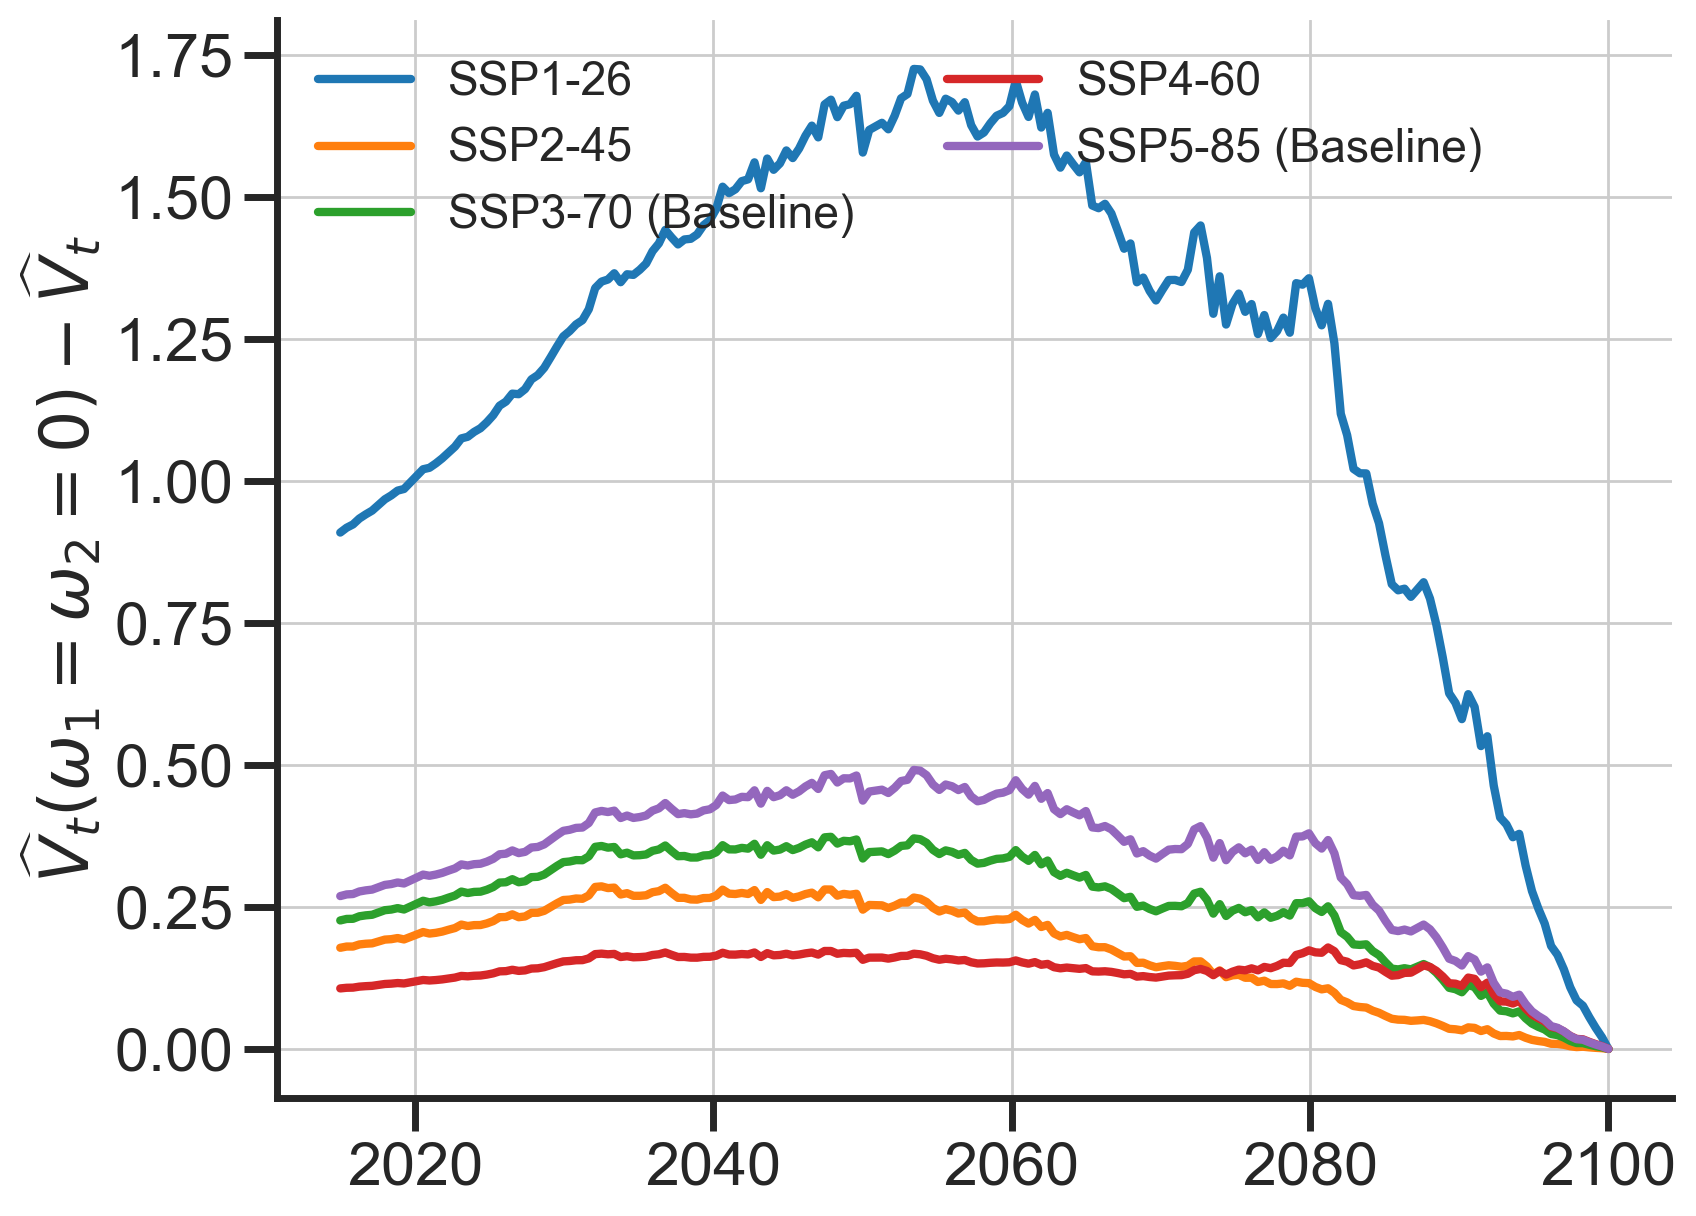

In [17]:
fig, ax = plt.subplots()
for scenario_name, value in value_dict.items():
    plt.plot(
        T_SSP_INITIAL + tab_t,
        value_no_pen - value,
        "-",
        label=scenario_name,
    )
ax.set_ylabel("$\\widehat{V}_t(\\omega_1=\\omega_2=0) - \\widehat{V}_t$")
ax.legend(loc="upper left", ncol=2, framealpha=0)
plt.show()

# Default probability

To calibrate the default boundary $L(t)$, we proceed as in Section 3.2 of the [paper](https://hal.science/hal-03458299/document).

Given a default intensity rate $\lambda_{\textrm{ref}}$, the default boundary $L(t)$ is determined such that

$$ \mathbb{P} \left(\widehat{V}_t (\omega_1=\omega_2=0) \leq L(t)\right) = 1 - e^{-\lambda_{\textrm{ref}} \, t}, $$

where $\widehat{V}_t (\omega_1=\omega_2=0)$ corresponds to the optimal obligor's value with no reward or penalization.


In [18]:
# Set default intensity
LAMBDA_REF = 0.03
sub_time = np.linspace(1.0, 50.0, 50)

In [19]:
tab_L = np.array(
    [
        Firm.default_boundary_unpenalized(
            t=t_, lbd_ref=LAMBDA_REF, firm_no_pen=firm_no_pen
        )
        for t_ in sub_time
    ]
).flatten()

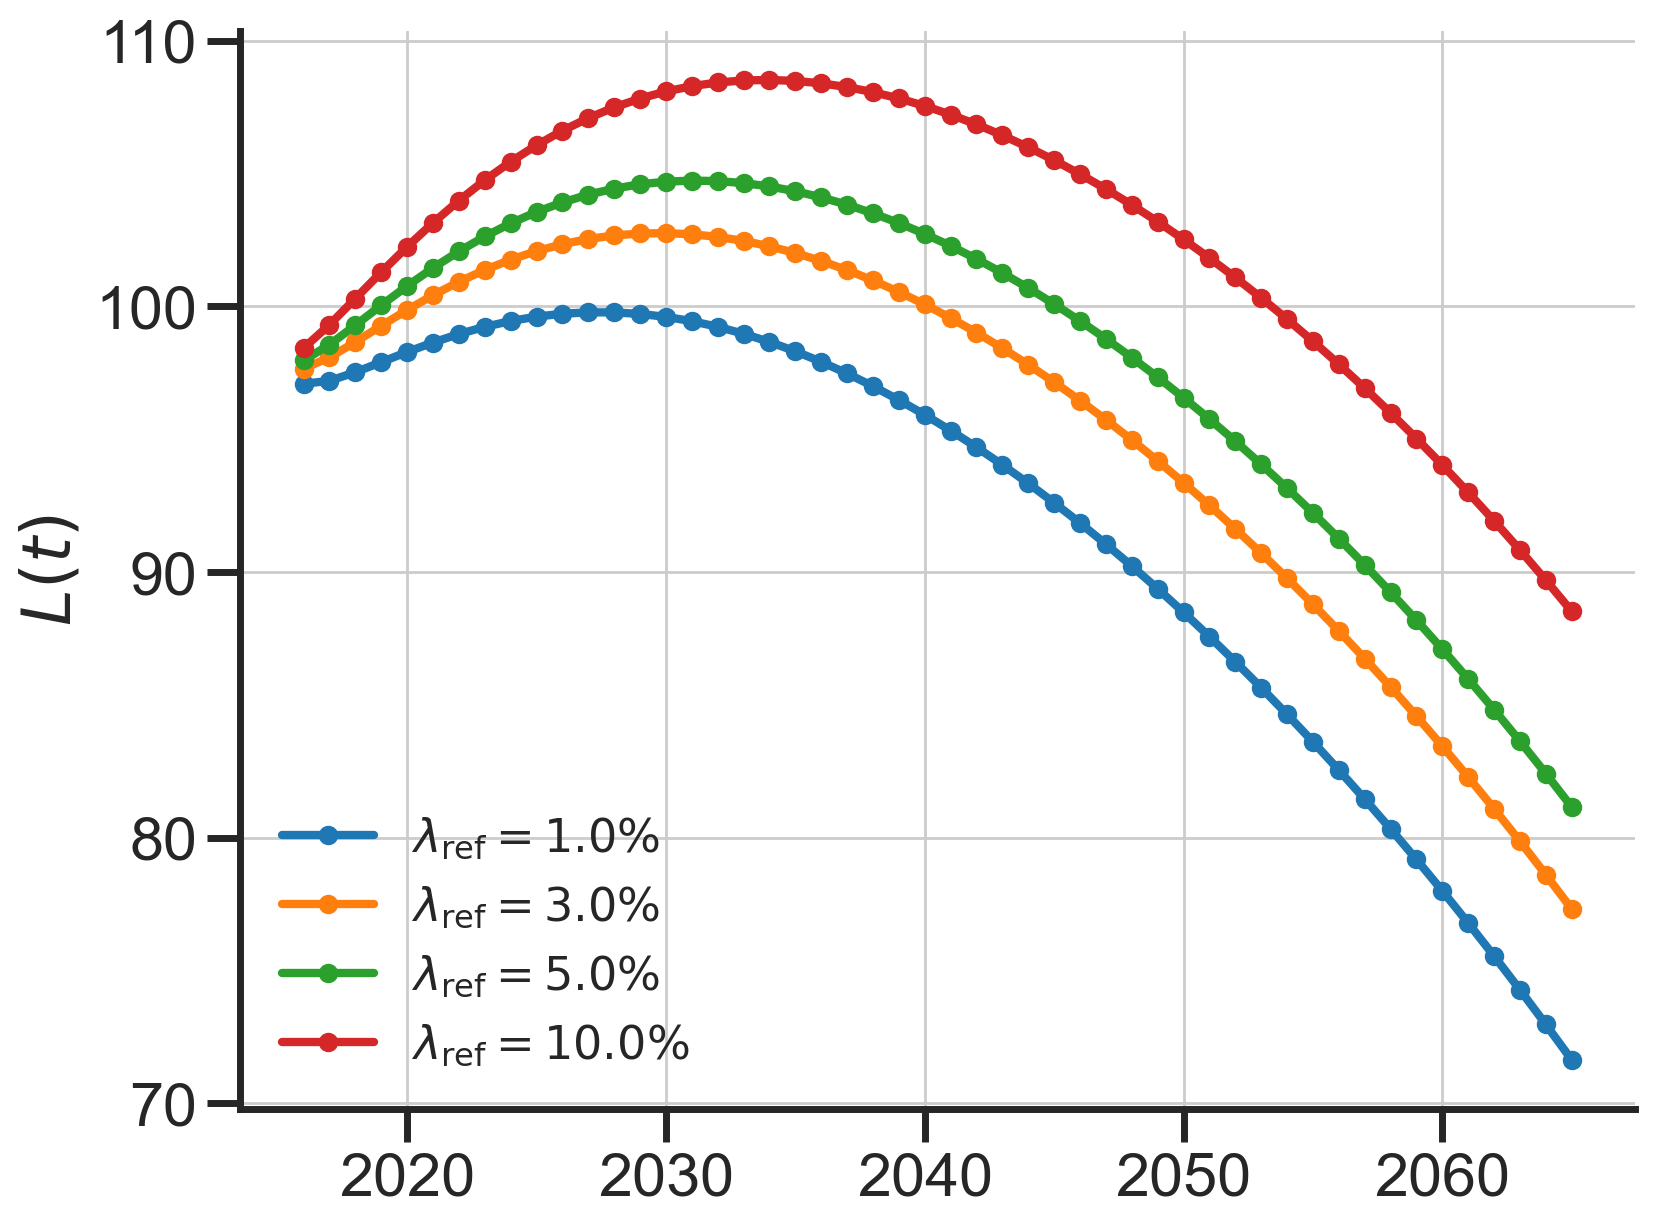

In [20]:
fig, ax = plt.subplots()
for lbd_ in [0.01, 0.03, 0.05, 0.10]:
    L_ = np.array(
        [
            Firm.default_boundary_unpenalized(
                t=t_, lbd_ref=lbd_, firm_no_pen=firm_no_pen
            )
            for t_ in sub_time
        ]
    ).flatten()
    ax.plot(
        T_SSP_INITIAL + sub_time,
        L_,
        ".-",
        label=f"$\\lambda_{{\\mathrm{{ref}}}} = {100 * lbd_} \\% $",
    )
ax.set_ylabel("$L(t)$")
ax.legend(framealpha=0)
plt.show()

At a given time $t \ge 0$, the probability of default is defined as

$$ \mathbb{P}(\widehat{V}_t \le L(t)) $$


In [21]:
prob_default_dict = {}
for scenario_name, firm in firms_dict.items():
    print(scenario_name)
    t0 = time.time()
    prob_default_dict[scenario_name] = np.array(
        [
            firm.proba_default_merton(
                t=t_,
                barrier_t=tab_L[i],
            )
            for i, t_ in enumerate(sub_time)
        ]
    ).flatten()
    t1 = time.time()
    print(f"time elapsed: {t1 - t0}")

SSP1-26
time elapsed: 4.021106004714966
SSP2-45
time elapsed: 3.964197874069214
SSP3-70 (Baseline)
time elapsed: 4.021343946456909
SSP4-60
time elapsed: 4.059891939163208
SSP5-85 (Baseline)
time elapsed: 3.9108927249908447


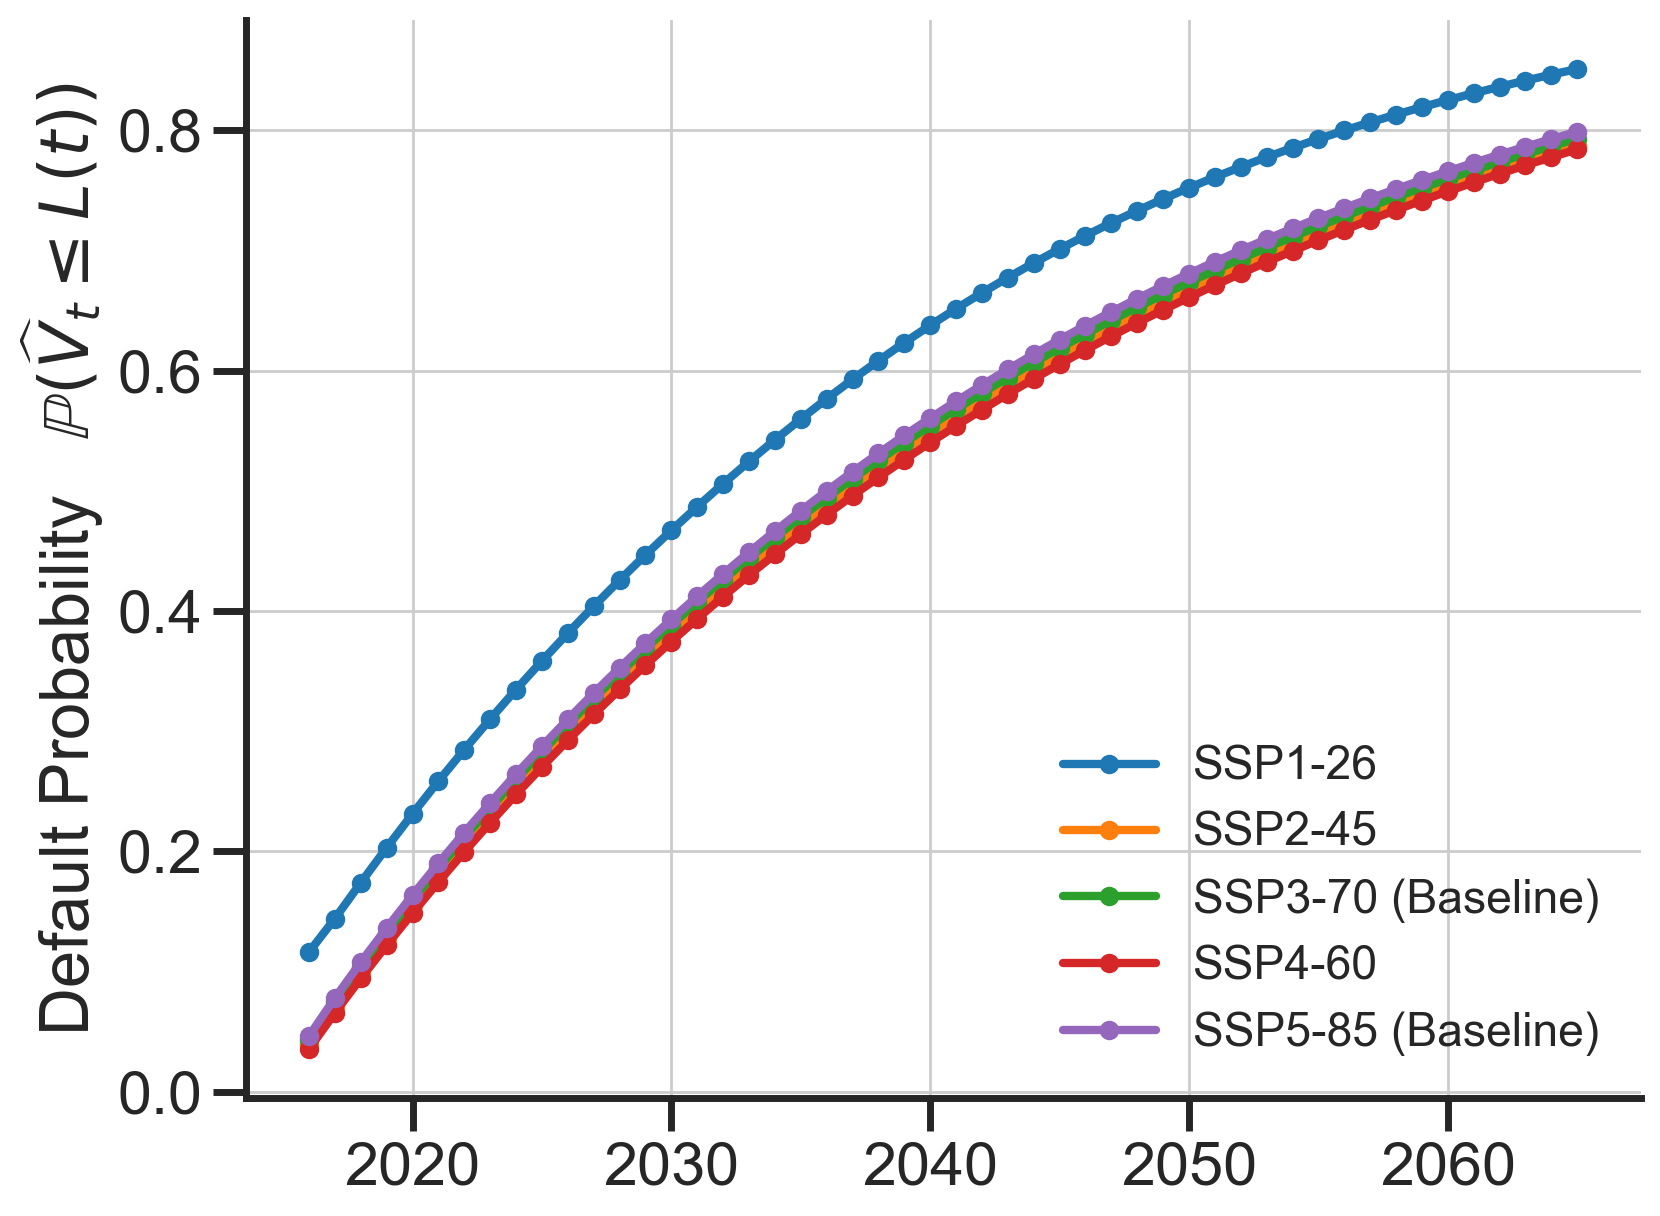

In [22]:
# Plot default probability for each scenario
fig, ax = plt.subplots()
for scenario_name, prob_default in prob_default_dict.items():
    ax.plot(T_SSP_INITIAL + sub_time, prob_default, ".-", label=scenario_name)
ax.set_ylabel(
    "Default Probability   $\\mathbb{P} (\\widehat{V}_t \\leq L(t))$",
)
ax.legend(loc="best", framealpha=0)
plt.show()

In [23]:
intensity_dict = {
    scenario_name_: Firm.default_intensity(
        tab_t=sub_time, prob_default=prob_default_firm
    )
    for scenario_name_, prob_default_firm in prob_default_dict.items()
}

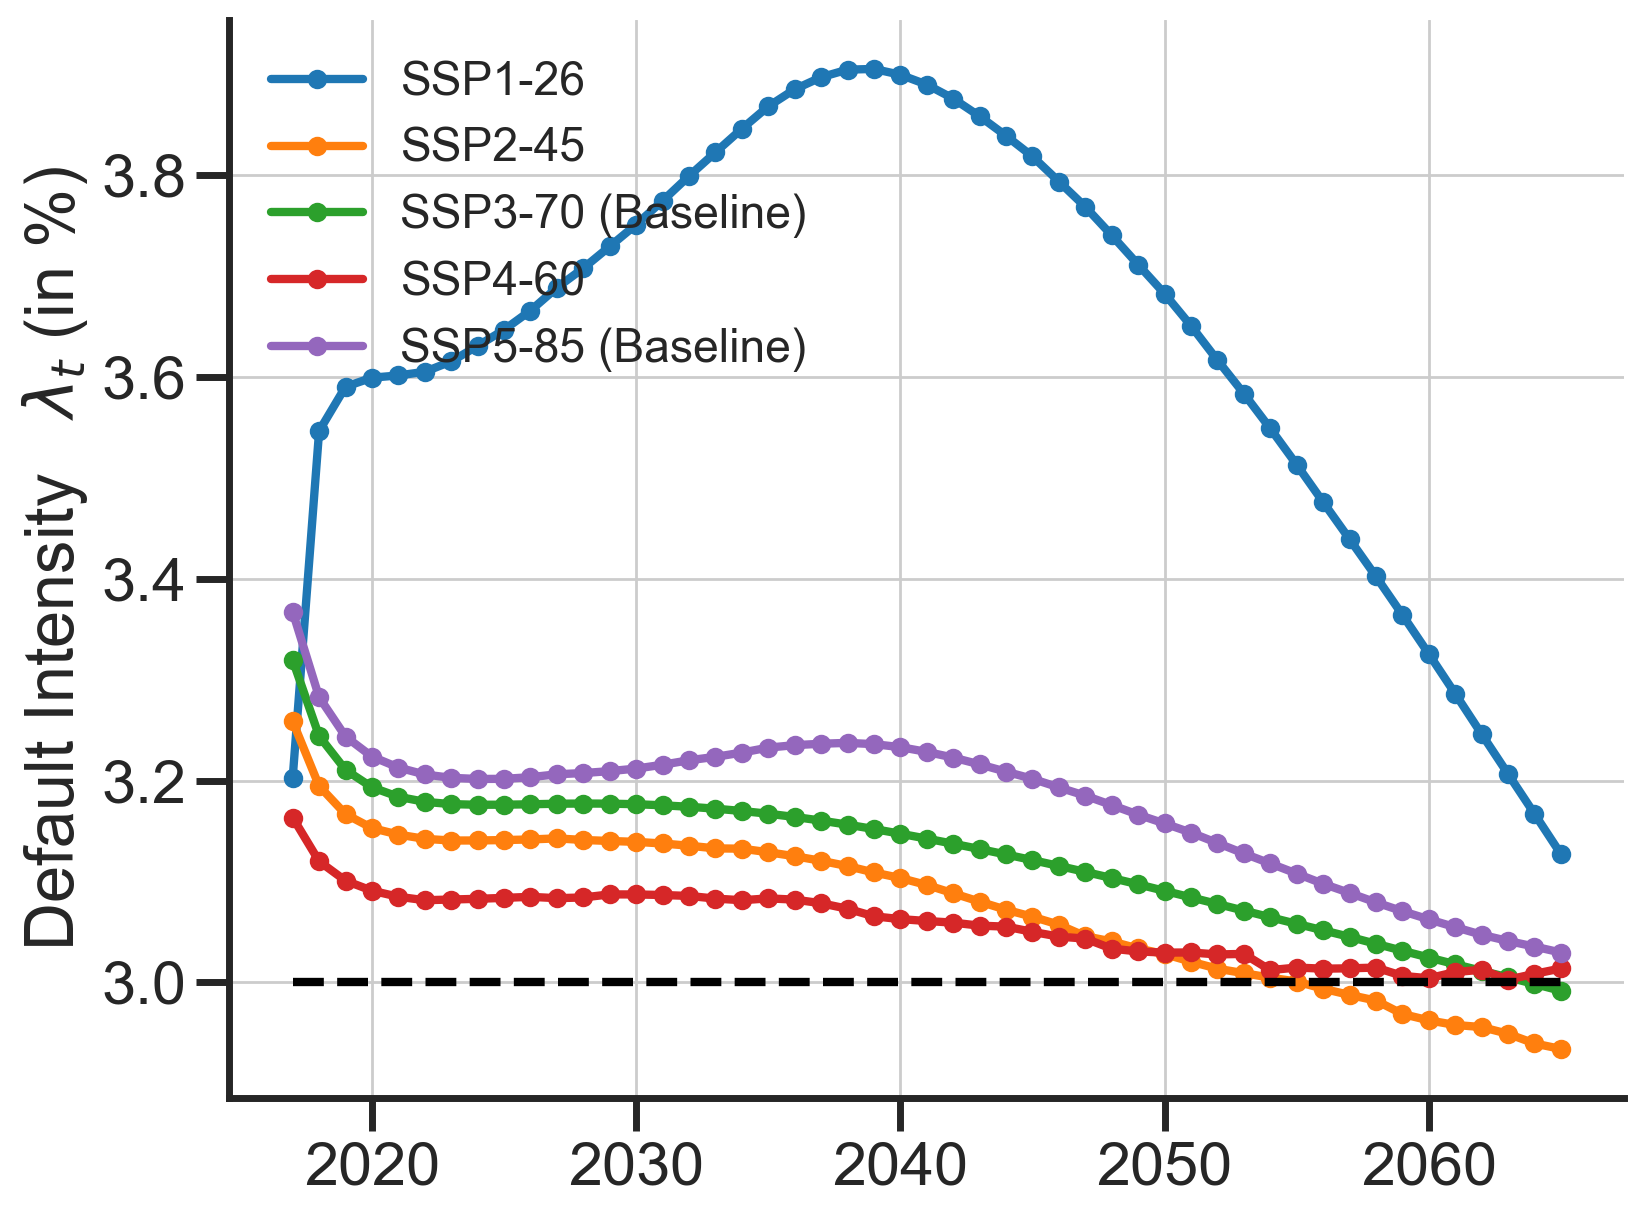

In [24]:
# Plot default intensity for each scenario
fig, ax = plt.subplots()
for name, intensity in intensity_dict.items():
    ax.plot(T_SSP_INITIAL + sub_time[1:], 100 * intensity, ".-", label=name)
ax.plot(
    T_SSP_INITIAL + sub_time[1:],
    100 * LAMBDA_REF * np.ones_like(sub_time[1:]),
    "k--",
    # label=f"$\\lambda={100 * lbd_ref}$%",
)
ax.set_ylabel("Default Intensity   $\\lambda_t$ (in %)")
ax.legend(loc="upper left", ncol=1, framealpha=0)
plt.show()